In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

data = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

cust_filter = data['cust_id'] == 'klant_69'
data = data.where(cust_filter).dropna()


data['procesdag']=pd.to_datetime(data['procesdag'])
data.set_index('procesdag', inplace=True)
data = data['2016-09-01':'2016-10-01']

data.head()

,cust_id,aantal_pakketten,aantal_pakketten_volgende_dag,validation_column
procesdag,,,,
2016-09-01,klant_69,702.0,470.0,train
2016-09-02,klant_69,470.0,0.0,train
2016-09-03,klant_69,0.0,933.0,train
2016-09-04,klant_69,933.0,468.0,train
2016-09-05,klant_69,468.0,504.0,train


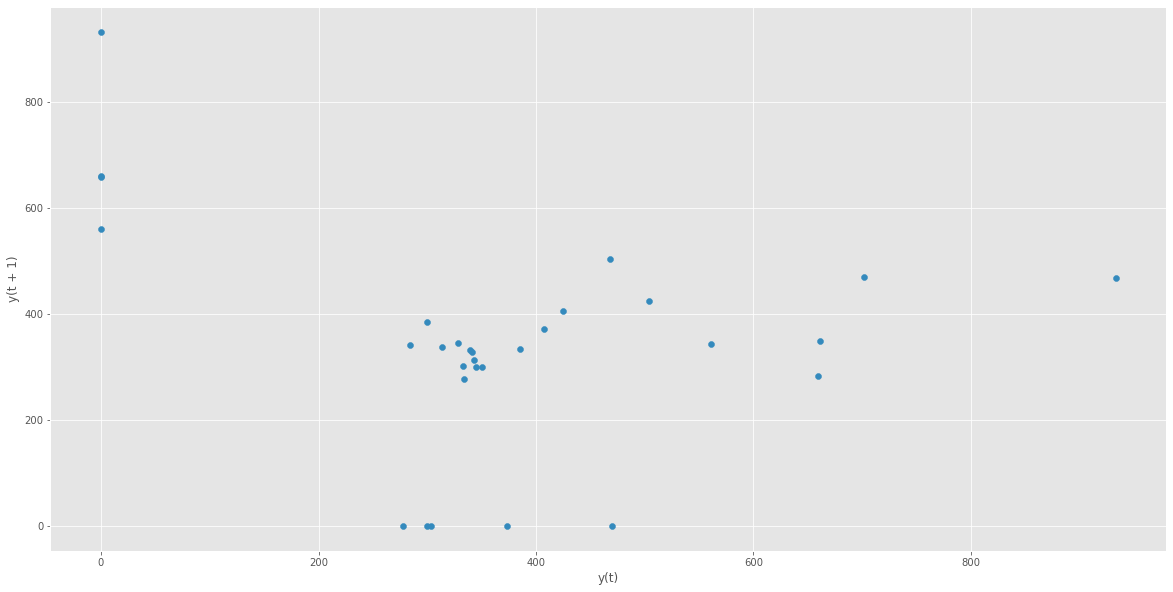

In [3]:
pd.plotting.lag_plot(data['aantal_pakketten'])

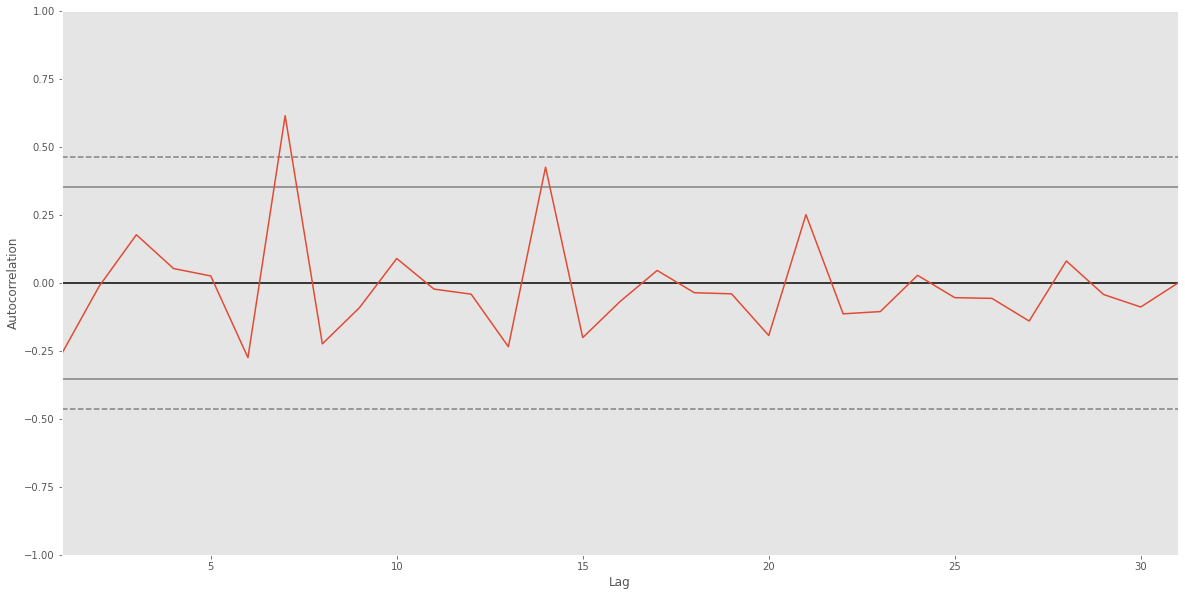

In [4]:
pd.plotting.autocorrelation_plot(data['aantal_pakketten'])

In [5]:
data['aantal_pakketten'].corr(data['aantal_pakketten'].shift(7))

0.9305395743633438

In [6]:
# data['stationary'] = data['aantal_pakketten'].diff()
# data['stationary']

In [7]:
from statsmodels.tsa.ar_model import AR

# Train/Test datasets
X = data['aantal_pakketten'].dropna()
train_data = X[:-7]
test_data = X[-7:]

In [8]:
data.shape

(31, 4)

In [9]:
train_data.shape

(24,)

In [10]:
test_data.shape

(7,)

In [11]:
train_data

procesdag
2016-09-01    702.0
2016-09-02    470.0
2016-09-03      0.0
2016-09-04    933.0
2016-09-05    468.0
2016-09-06    504.0
2016-09-07    425.0
2016-09-08    407.0
2016-09-09    373.0
2016-09-10      0.0
2016-09-11    661.0
2016-09-12    350.0
2016-09-13    300.0
2016-09-14    385.0
2016-09-15    334.0
2016-09-16    278.0
2016-09-17      0.0
2016-09-18    659.0
2016-09-19    284.0
2016-09-20    341.0
2016-09-21    328.0
2016-09-22    345.0
2016-09-23    300.0
2016-09-24      0.0
Name: aantal_pakketten, dtype: float64

In [12]:
test_data

procesdag
2016-09-25    561.0
2016-09-26    343.0
2016-09-27    314.0
2016-09-28    339.0
2016-09-29    333.0
2016-09-30    303.0
2016-10-01      0.0
Name: aantal_pakketten, dtype: float64

In [13]:
# Train AR model
model = AR(train_data)
model_fitted = model.fit()

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWa

In [14]:
print('The lag value chose is: %s' % model_fitted.k_ar)
print('The coefficients of the model are:\n %s' % model_fitted.params)

The lag value chose is: 8
The coefficients of the model are:
 const                  410.282153
L1.aantal_pakketten     -0.536384
L2.aantal_pakketten     -0.192473
L3.aantal_pakketten     -0.090196
L4.aantal_pakketten     -0.076193
L5.aantal_pakketten     -0.131479
L6.aantal_pakketten     -0.172486
L7.aantal_pakketten      0.612896
L8.aantal_pakketten      0.230100
dtype: float64


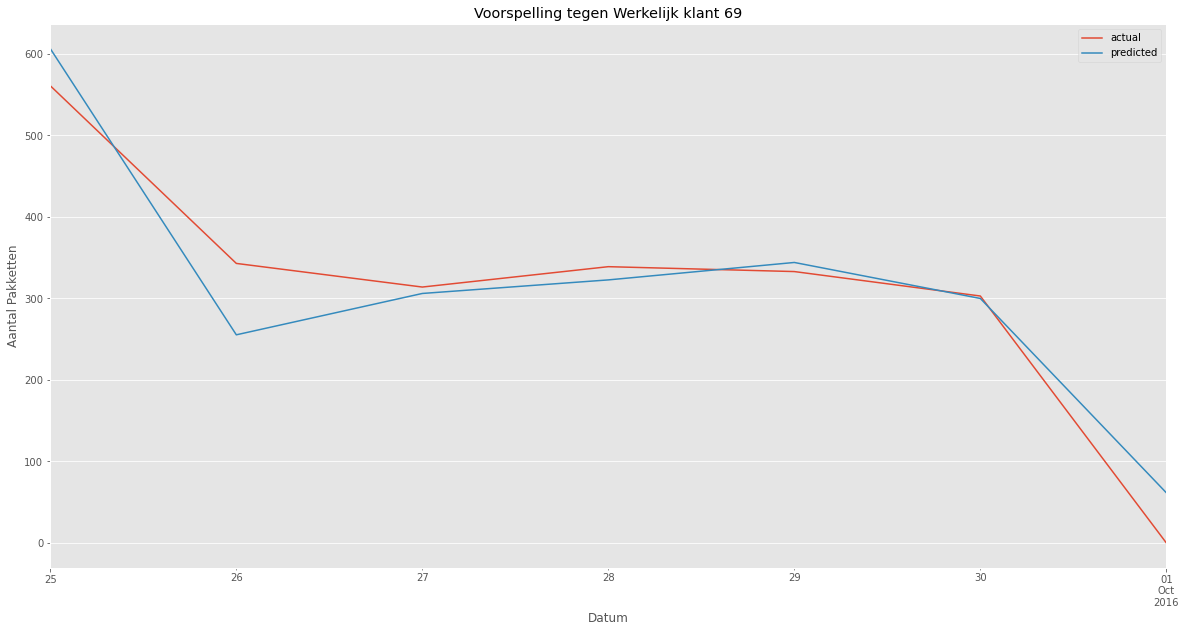

In [15]:
# make predictions
predictions = model_fitted.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data)-1,
    dynamic=False)

# create comparison dataframe
compare_data = pd.concat([data['aantal_pakketten'].tail(7), predictions], axis=1).rename(columns={'aantal_pakketten':'actual', 0:'predicted'})

compare_data.plot(
ylabel = 'Aantal Pakketten',
xlabel = 'Datum',
title = 'Voorspelling tegen Werkelijk klant 69')

In [16]:
compare_data

,actual,predicted
2016-09-25,561.0,606.509344
2016-09-26,343.0,255.370566
2016-09-27,314.0,306.121202
2016-09-28,339.0,322.769814
2016-09-29,333.0,344.164431
2016-09-30,303.0,299.995094
2016-10-01,0.0,61.530206


In [17]:
diff = compare_data.actual - compare_data.predicted

Text(0, 0.5, '$\\hat{y}$')

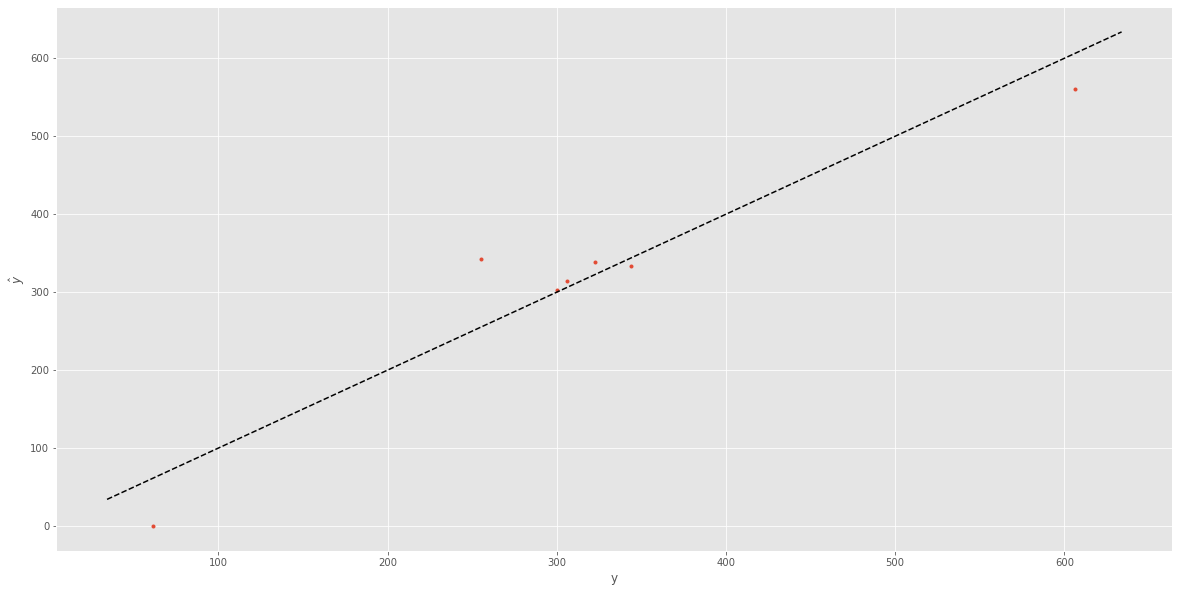

In [18]:
plt.plot(compare_data.predicted, compare_data.actual, ".")
plt.plot(plt.xlim(), plt.xlim(), ls="--", c='black')
plt.xlabel("y")
plt.ylabel("$\hat{y}$")

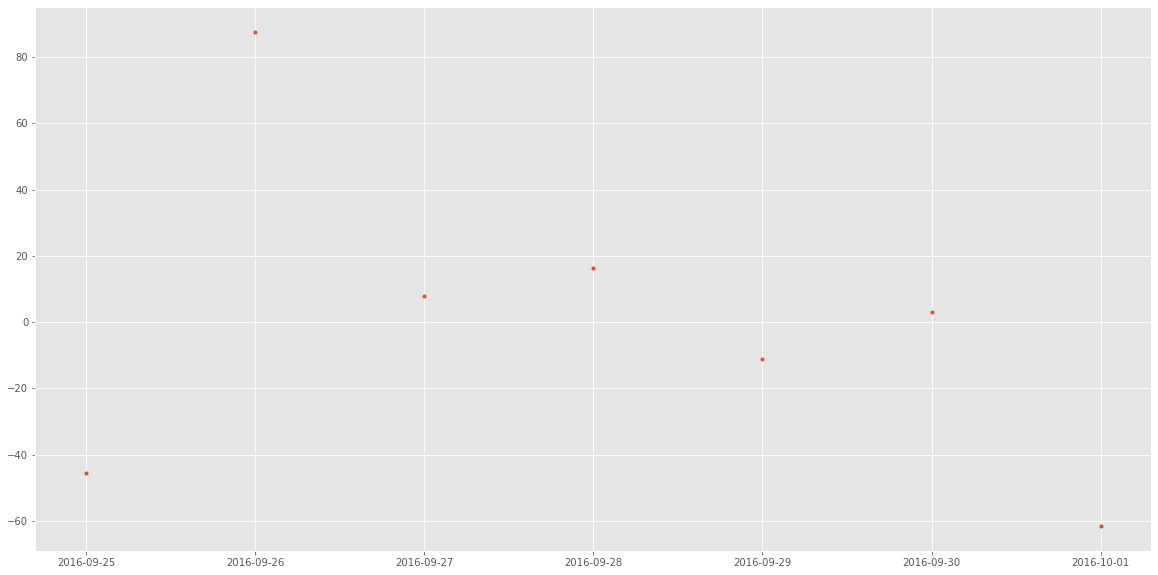

In [19]:
plt.plot(diff, ".")

(array([1., 1., 0., 1., 2., 1., 0., 0., 0., 1.]),
 array([-61.53020636, -46.61424232, -31.69827828, -16.78231424,
         -1.8663502 ,  13.04961384,  27.96557788,  42.88154192,
         57.79750596,  72.71347   ,  87.62943404]),
 <a list of 10 Patch objects>)

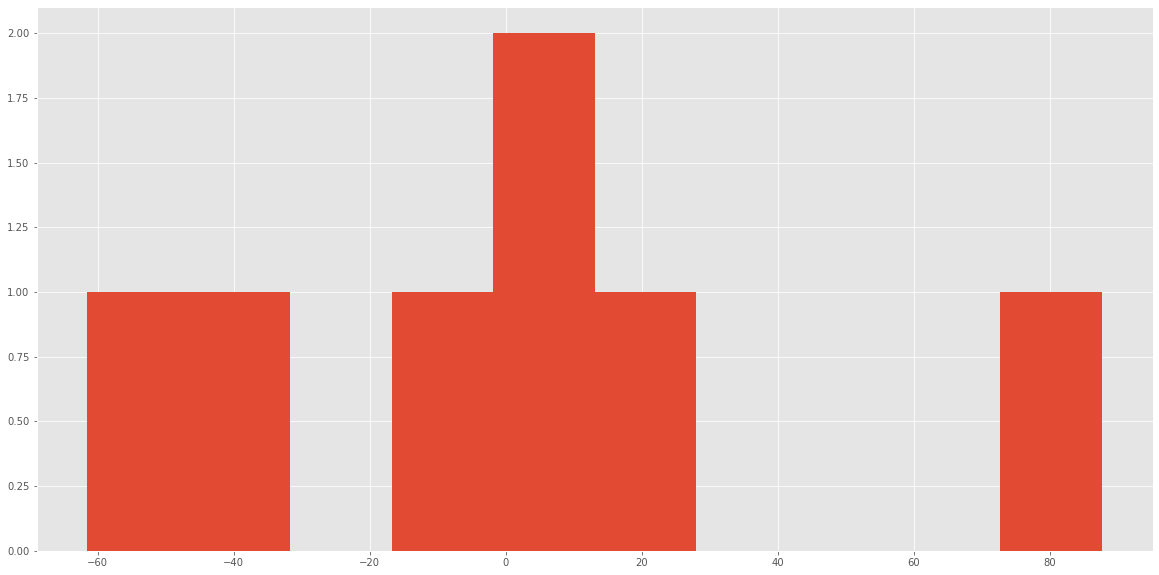

In [20]:
plt.hist(diff)